# Population of Izmir's towns
- population of each town is taken from TUIK as CSV file
- populations will be inserted into Turkey's geodataframe from Turkeys province shape file.
- Province names and populations will be placed on the map

In [1]:
%matplotlib inline

import pandas as pd
import geopandas

In [3]:
province_centers = geopandas.read_file("zip://./data/turkey-places-shape.zip", encoding = 'utf-8')
province_centers = province_centers.rename(columns={'name': 'town'})
province_centers = province_centers.loc[province_centers['type'] == 'town']
province_centers.head()

,osm_id,town,type,population,geometry
0,14644309,İskenderun,town,0,POINT (36.176633 36.5858985)
4,25869577,Kırklareli,town,70000,POINT (27.2235523 41.7370223)
32,26482024,Eğirdir,town,0,POINT (30.8490411 37.8741256)
33,26482164,Keçiborlu,town,0,POINT (30.301065 37.944434)
80,26504188,Havsa,town,0,POINT (26.823503 41.54839)


### province and towns shape files
gadm36_TUR_0.shp Turkey in general  
gadm36_TUR_1.shp Turkey/provinces  
gadm36_TUR_2.shp Turkey/towns  
shape files can be download at https://gadm.org/index.html  
* town file does not contain Bayraklı and Karabağlar

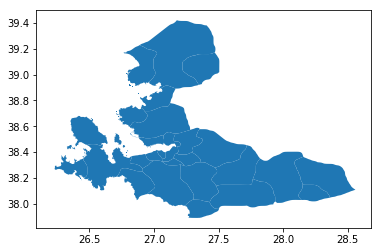

In [62]:
towns = geopandas.read_file("data/gadm36_TUR_2.shp", encoding = 'utf-8')
izmir_towns = towns.loc[towns['NAME_1'] == 'Izmir']
izmir_towns = izmir_towns[['NAME_2','geometry']]
izmir_towns = izmir_towns.rename(columns={'NAME_2': 'town'})
izmir_towns.plot()

## Load population from TUIK data
Read from csv file take from TUIK website https://biruni.tuik.gov.tr/medas/  
-skip 5 rows since they are scrambled from source

In [63]:
df = pd.read_csv("data/izmir_population.csv", sep='|', usecols=["year", "town", "population"]
                , index_col=False, header=None, skiprows=5, encoding = 'utf-8'
                , names=['year', 'town', 'population', 'value'])

There are NaN values on year column so it should ve filled with previous column.  
Last row is added from a empty line is csv so it should be removed

In [64]:
df=df.fillna(method='ffill') # fill NaN with previous row value
df=df[:-1] #remove last row

## Data clean up
-convert year and population to integer


In [65]:
df[['year','population']] = df[['year','population']].astype(int)
df.head()

,year,town,population
0,2007,İzmir(Aliağa)-1128,60043
1,2007,İzmir(Balçova)-2006,74837
2,2007,İzmir(Bayındır)-1178,42152
3,2007,İzmir(Bergama)-1181,102581
4,2007,İzmir(Beydağ)-1776,13500


extract string in the ()  
İzmir(Aliağa) --> Aliağa  


In [66]:
df['town']=df['town'].apply(lambda st: st[st.find("(")+1:st.find(")")])

Select only year 2017

In [67]:
df_year2017 = df.loc[df['year'] == 2017]
df_year2017.head()

,year,town,population
298,2017,Aliağa,94070
299,2017,Balçova,78442
300,2017,Bayındır,40258
301,2017,Bayraklı,314402
302,2017,Bergama,102961


### Merge shp dataframe with population
In merge, first dataframe SHOULD BE geopandas dataframe os resulting merge will be a geopandas dataframe.

In [99]:
town_pop = pd.merge(izmir_towns, df_year2017, on='town', how='inner')
town_pop_mercador = town_pop.to_crs(epsg=3395)

## Map

In [100]:
import matplotlib.pyplot as plt

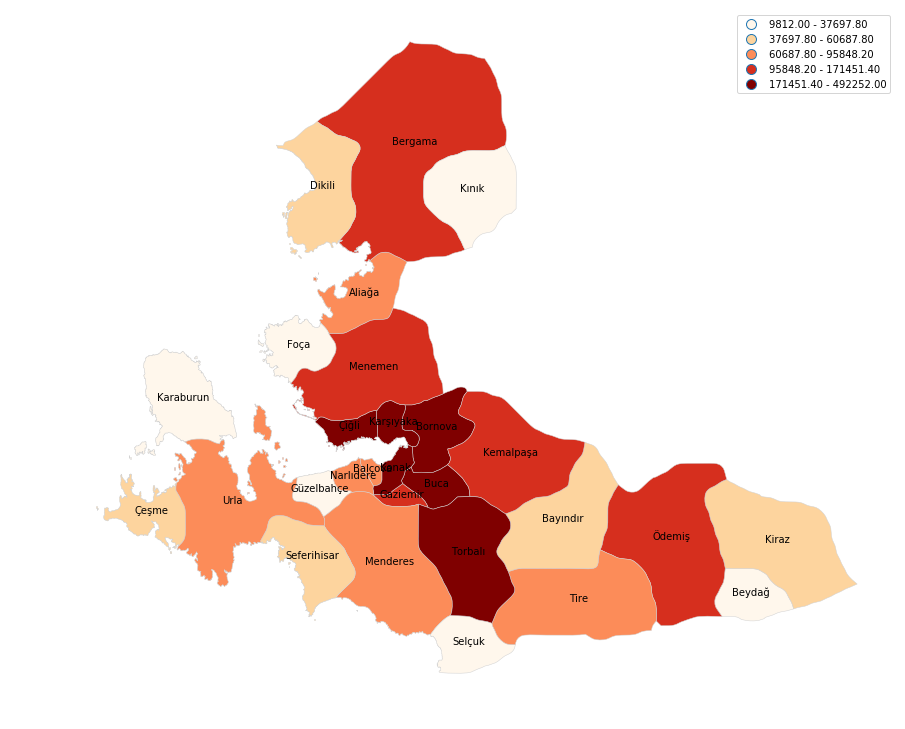

In [102]:
ax = town_pop_mercador.plot(figsize = (15, 15), edgecolor = "lightgrey", linewidth = 0.5, 
                   column='population', cmap='OrRd', scheme='quantiles', legend=True)
ax.set_axis_off()
town_pop_mercador.apply(lambda x: ax.annotate(s=x.town, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);